<a href="https://colab.research.google.com/github/Followb1ind1y/Face-Mask-Detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real-Time Face Mask Detection**

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import time
import os
import copy
import cv2
import matplotlib.pyplot as plt

In [2]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**Dataset Preparation**

In [ ]:
!mkdir FaceMask
!unzip /content/gdrive/MyDrive/archive1.zip -d /content/FaceMask

In [5]:
import os
import xml.etree.ElementTree as ET

imageset_dir = '/content/FaceMask/images'
annotations_dir = '/content/FaceMask/annotations'
file_name = 'maksssksksss'

anno_dict = [0, 0, 0]

imageset_len = len([name for name in os.listdir(imageset_dir) if os.path.isfile(os.path.join(imageset_dir, name))])
print("There are", imageset_len, "images in the dataset.")

for idx in range(imageset_len):
    curr_file_dir = os.path.join(annotations_dir, file_name+str(idx)+'.xml')
    tree = ET.parse(curr_file_dir)
    root = tree.getroot()
    for neighbor in root.iter('object'):
        label = neighbor.find('name').text
        if label == 'with_mask': anno_dict[0]+=1
        elif label == 'without_mask': anno_dict[1]+=1
        else: anno_dict[2]+=1

print("There are", anno_dict[0], "with_mask annotations", 
      anno_dict[1], "without_mask annotations", 
      anno_dict[2], "mask_weared_incorrect annotations.")

There are 853 images in the dataset.
There are 3232 with_mask annotations 717 without_mask annotations 123 mask_weared_incorrect annotations.


In [6]:
import os
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw, ImageFont

def get_annotations_boxes_from_xml(dir):
    tree = ET.parse(dir)
    root = tree.getroot()

    annotations, labels = [], []

    for neighbor in root.iter('bndbox'):
        xmin = int(neighbor.find('xmin').text)
        ymin = int(neighbor.find('ymin').text)
        xmax = int(neighbor.find('xmax').text)
        ymax = int(neighbor.find('ymax').text)

        annotations.append([xmin, ymin, xmax, ymax])
    
    for neighbor in root.iter('object'):
        label = neighbor.find('name').text
        if label == 'without_mask': 
            labels.append(2)
        else:
            labels.append(1)

    return annotations, labels

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import splitfolders

root_dir = '/content/FaceMask'
splitfolders.ratio(root_dir, output="train_split", seed=42, ratio=(0.8, 0.1, 0.1))
output_dir = '/content/train_split'

Copying files: 1706 files [00:01, 1138.37 files/s]


In [9]:
import os
import numpy as np
import torch

from torchvision import transforms
from PIL import Image

class FaceMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'images'))))
        self.anns = list(sorted(os.listdir(os.path.join(root, 'annotations'))))
        self.img_dir = os.path.join(root, 'images')
        self.ann_dir  = os.path.join(root, 'annotations')
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        curr_img_dir = os.path.join(self.img_dir, self.imgs[idx])
        curr_ann_dir = os.path.join(self.ann_dir, self.anns[idx])

        image = Image.open(curr_img_dir, mode='r').convert('RGB')
        boxes, labels = get_annotations_boxes_from_xml(curr_ann_dir)

        boxes = torch.FloatTensor(boxes)
        labels = torch.LongTensor(labels)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, category_ids=labels)

        tenn = transforms.ToTensor()
        image = tenn(image)

        return image, boxes, labels

    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [10]:
import albumentations as A

data_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

In [11]:
Batch_Size = 4

image_datasets = {x: FaceMaskDataset(root=os.path.join(output_dir, x), transforms=None) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_Size,
                                              shuffle=True, collate_fn=image_datasets[x].collate_fn) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
from PIL import Image, ImageDraw, ImageFont

def display_boundary(image, boxes, labels, score = None):

    label_to_name = {1: 'Masked', 2: 'No Mask', }
    label_to_color = {1: 'palegreen', 2: 'red'}

    transform = torchvision.transforms.ToPILImage()
    image = transform(image)
    boxes = boxes.tolist()
    labels = labels.tolist()

    img_bbox = ImageDraw.Draw(image)
    new_font = ImageFont.truetype(os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSansCondensed-Bold.ttf'), 10)

    for idx in range(len(boxes)):
        img_bbox.rectangle(boxes[idx], outline=label_to_color[labels[idx]], width=2)
        if score == None: 
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]], 
                          font=new_font, align ="left", fill=label_to_color[labels[idx]]) 
        else:
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]]+' '+ f"{score[idx].item():.2%}", 
                          font=new_font, align ="left", fill=label_to_color[labels[idx]])
    
    return image

# helper function for image visualization
def display_images(**images):
    """
    Plot images in one rown
    """
    num_images = len(images)
    plt.figure(figsize=(15,15))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()

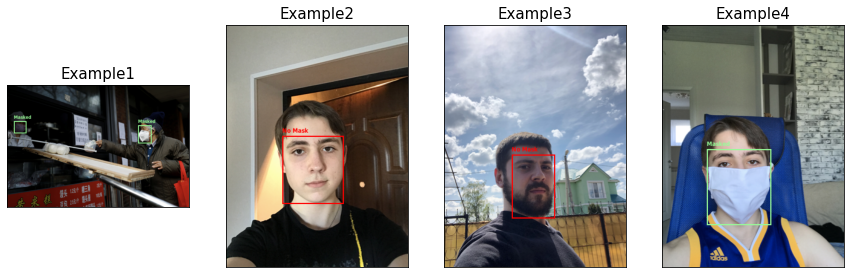

In [13]:
images, boxes, labels = next(iter(dataloaders['train']))

display_images(Example1=display_boundary(images[0], boxes[0], labels[0]),
        Example2=display_boundary(images[1], boxes[1], labels[1]),
        Example3=display_boundary(images[2], boxes[2], labels[2]),
        Example4=display_boundary(images[3], boxes[3], labels[3]))

## **Model Loading**

In [14]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
# model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

## **Training Model**

In [ ]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path

# Save the model to the target dir
def save_model(model: torch.nn.Module, target_dir: str, epoch: int):
    """
    Saves a PyTorch model to a target directory.
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    check_point_name = f"model_epoch_{epoch}"
    model_save_path = target_dir_path / check_point_name

    # Save the model state_dict()
    #print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

# Plot the training curve
def plot_curve(results: dict, epochs: int):
    #train_ious, val_ious = np.array(results["train_iou"]), np.array(results["val_iou"])
    train_losses = np.array(results["train_loss"])

    plt.plot(np.arange(epochs, step=1), train_losses, label='Train loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes
    """
    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""

import torch
import time
import utils
import numpy as np

from tqdm import trange

class Trainer:
    def __init__(self, 
                 model: torch.nn.Module,
                 dataloaders: torch.utils.data.DataLoader,
                 epochs: int, 
                 metric: torch.nn.Module, 
                 criterion: torch.nn.Module, 
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 save_dir: str,
                 device: torch.device):
        
        self.model = model
        self.train_dataloader = dataloaders['train']
        self.val_dataloader = dataloaders['val']
        self.epoch = 0
        self.epochs = epochs
        self.metric = None
        self.criterion = None
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = save_dir
        self.device = device

        # Create empty results dictionary
        self.results = {"train_loss": [],
                        "train_iou": [],
                        "val_loss": [],
                        "val_iou": []
                        }
        
    def train_model(self):
        """
        Train the Model.
        """
        start_time = time.time()

        progressbar = trange(self.epochs, desc="Progress")
        for _ in progressbar:
            # Epoch counter
            self.epoch += 1
            #progressbar.set_description(f"Epoch {self.epoch}")

            # Training block
            self.train_epoch()
            print(f'\nEpoch {self.epoch}: Train loss: {self.results["train_loss"][-1]}')

            # Save checkpoints every epoch
            utils.save_model(self.model, self.save_dir, self.epoch)

        time_elapsed = time.time() - start_time
        print('\n')
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # plot training curve
        utils.plot_curve(results=self.results, epochs=self.epochs)

        return self.results

    def train_epoch(self):
        """
        Training Mode
        """
        self.model.train() # training mode
        running_losses = []

        for images, boxes, labels in self.train_dataloader:
            # Send to device (GPU or CPU)
            images = list(img.to(self.device) for img in images)
            boxes = [b.to(self.device) for b in boxes]
            labels = [l.to(self.device) for l in labels]
            targets = []

            for i in range(len(images)):
                d = {}
                d['boxes'] = boxes[i]
                d['labels'] = labels[i]
                targets.append(d)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward - track history if only in train
            loss_dict = self.model(images, targets)
            # Calculate the loss
            loss = sum(loss for loss in loss_dict.values())
            loss_value = loss.item()
            running_losses.append(loss_value)

            # Backward pass
            loss.backward()
            # Update the parameters
            self.optimizer.step()

        self.scheduler.step()
        self.results["train_loss"].append(np.mean(running_losses))

    def val_epoch(self):
        """
        Validation Mode
        """
        self.model.eval() # Validation mode
        running_ious, running_losses = [], []

        for x, y in self.val_dataloader:
            # Send to device (GPU or CPU)
            inputs = x.to(self.device)
            targets = y.to(self.device)

            with torch.no_grad():
                outputs = self.model(inputs)
                # Calculate the loss
                loss = self.criterion(outputs, targets)
                loss_value = loss.item()
                running_losses.append(loss_value)

                # Calculate the iou
                iou_value = self.metric(outputs, targets)
                running_ious.append(iou_value)

        self.results["val_loss"].append(np.mean(running_losses))
        self.results["val_iou"].append(np.mean(running_ious))

Progress:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1: Train loss: 0.6100017451926282


Progress:   4%|▍         | 1/25 [00:42<16:59, 42.50s/it]


Epoch 2: Train loss: 0.4801826644362065


Progress:   8%|▊         | 2/25 [01:22<15:41, 40.91s/it]


Epoch 3: Train loss: 0.4791002819935481


Progress:  12%|█▏        | 3/25 [02:03<15:04, 41.12s/it]


Epoch 4: Train loss: 0.44242437044430893


Progress:  16%|█▌        | 4/25 [02:42<14:08, 40.38s/it]


Epoch 5: Train loss: 0.4441667916307672


Progress:  24%|██▍       | 6/25 [03:59<12:26, 39.31s/it]


Epoch 6: Train loss: 0.4064047240722946

Epoch 7: Train loss: 0.3906656820000264


Progress:  28%|██▊       | 7/25 [04:38<11:41, 38.98s/it]


Epoch 8: Train loss: 0.3133659113568869


Progress:  32%|███▏      | 8/25 [05:16<10:58, 38.73s/it]


Epoch 9: Train loss: 0.2914918982668927


Progress:  36%|███▌      | 9/25 [05:54<10:14, 38.39s/it]


Epoch 10: Train loss: 0.28297712971941075


Progress:  40%|████      | 10/25 [06:32<09:35, 38.37s/it]


Epoch 11: Train loss: 0.27895747072863997


Progress:  48%|████▊     | 12/25 [07:47<08:13, 37.97s/it]


Epoch 12: Train loss: 0.27315067669801546


Progress:  52%|█████▏    | 13/25 [08:25<07:35, 37.96s/it]


Epoch 13: Train loss: 0.26467621095522104


Progress:  56%|█████▌    | 14/25 [09:03<06:55, 37.81s/it]


Epoch 14: Train loss: 0.26190720280708624


Progress:  60%|██████    | 15/25 [09:40<06:17, 37.76s/it]


Epoch 15: Train loss: 0.2464743454379645

Epoch 16: Train loss: 0.24721820896480515


Progress:  68%|██████▊   | 17/25 [10:55<05:00, 37.55s/it]


Epoch 17: Train loss: 0.2416163510397861


Progress:  72%|███████▏  | 18/25 [11:32<04:22, 37.47s/it]


Epoch 18: Train loss: 0.23687329613848737


Progress:  76%|███████▌  | 19/25 [12:10<03:45, 37.50s/it]


Epoch 19: Train loss: 0.2405668964598611


Progress:  80%|████████  | 20/25 [12:48<03:07, 37.55s/it]


Epoch 20: Train loss: 0.24193074166426184

Epoch 21: Train loss: 0.24329211323233377


Progress:  88%|████████▊ | 22/25 [14:02<01:52, 37.48s/it]


Epoch 22: Train loss: 0.2379191018510283


Progress:  92%|█████████▏| 23/25 [14:40<01:15, 37.56s/it]


Epoch 23: Train loss: 0.24235876527620337


Progress:  96%|█████████▌| 24/25 [15:18<00:37, 37.62s/it]


Epoch 24: Train loss: 0.2393529385066869


Progress: 100%|██████████| 25/25 [15:55<00:00, 38.23s/it]


Epoch 25: Train loss: 0.24172632966996632


--------------------
Training complete in 15m 56s


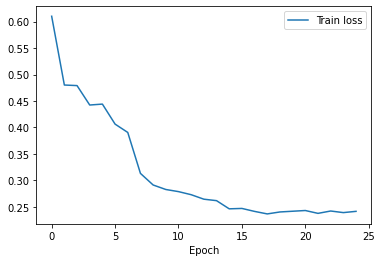

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

## Unet effb4 batch size 16 lr 0.001 argumentation
## Model inItialization
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer_RCNN = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler_RCNN = lr_scheduler.StepLR(optimizer_RCNN, step_size=7, gamma=0.1)

# Trainer
trainer = Trainer(model=model,
                  dataloaders=dataloaders,
                  epochs=25,
                  metric=None,
                  criterion=None, 
                  optimizer=optimizer_RCNN,
                  scheduler=exp_lr_scheduler_RCNN,
                  save_dir="RCNN_Model_Output",
                  device=device)

## Training process
model_results = trainer.train_model()

In [15]:
import torch.optim as optim
from torch.optim import lr_scheduler

model_state = torch.load('/content/model_epoch_25')
model.load_state_dict(model_state)

## Unet effb4 batch size 16 lr 0.001 argumentation
## Model inItialization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer_UNet = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler_UNet = lr_scheduler.StepLR(optimizer_UNet, step_size=7, gamma=0.1)

In [17]:
def remove_low_risk_box(predictions, threshold):

    for img in range(len(predictions)):
        for idx in range(predictions[img]['labels'].shape[0]):
            if predictions[img]['scores'][idx] < threshold:
                predictions[img]['boxes'] = predictions[img]['boxes'][0:idx]
                predictions[img]['labels'] = predictions[img]['labels'][0:idx]
                predictions[img]['scores'] = predictions[img]['scores'][0:idx]
                break

    return predictions
    
def nms_pytorch(P : torch.tensor, labels: torch.tensor, scores: torch.tensor, thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """
 
    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
 
    # we extract the confidence scores as well
    #scores = P[:, 4]
 
    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
     
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()
 
    # initialise an empty list for 
    # filtered prediction boxes
    pred_dict = {'boxes':[], 'labels':[], 'scores':[]}
     
 
    while len(order) > 0:
         
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]
 
        # push S in filtered predictions list
        if len(pred_dict['boxes']) == 0:
            pred_dict['boxes'].append(torch.unsqueeze(P[idx], dim=0))
            pred_dict['labels'].append(torch.unsqueeze(labels[idx], dim=0))
            pred_dict['scores'].append(torch.unsqueeze(scores[idx], dim=0))
        else:
            pred_dict['boxes'][0] = torch.cat((pred_dict['boxes'][0], torch.unsqueeze(P[idx], dim=0)), dim=0)
            pred_dict['labels'][0] = torch.cat((pred_dict['labels'][0], torch.unsqueeze(labels[idx], dim=0)), dim=0)
            pred_dict['scores'][0] = torch.cat((pred_dict['scores'][0], torch.unsqueeze(scores[idx], dim=0)), dim=0)
 
        # remove S from P
        order = order[:-1]
 
        # sanity check
        if len(order) == 0:
            break
         
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)
 
        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
 
        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
         
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
 
        # find the intersection area
        inter = w*h
 
        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
 
        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
         
        # find the IoU of every prediction in P with S
        IoU = inter / union
 
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
    
    pred_dict['boxes'], pred_dict['labels'], pred_dict['scores'] = pred_dict['boxes'][0], pred_dict['labels'][0], pred_dict['scores'][0]
    return pred_dict

def apply_nms(predictions, threshold):
    nms_list = []
    for img in range(len(predictions)):
        nms_list.append(nms_pytorch(predictions[img]['boxes'], predictions[img]['labels'], predictions[img]['scores'], threshold))
    return nms_list

## **Evaluation on Testset**

In [21]:
images, boxes, labels = next(iter(dataloaders['test']))
images = list(img.to(device) for img in images)

model.eval()
predictions = model(images)
predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)
predictions = apply_nms(predictions, 0.5)

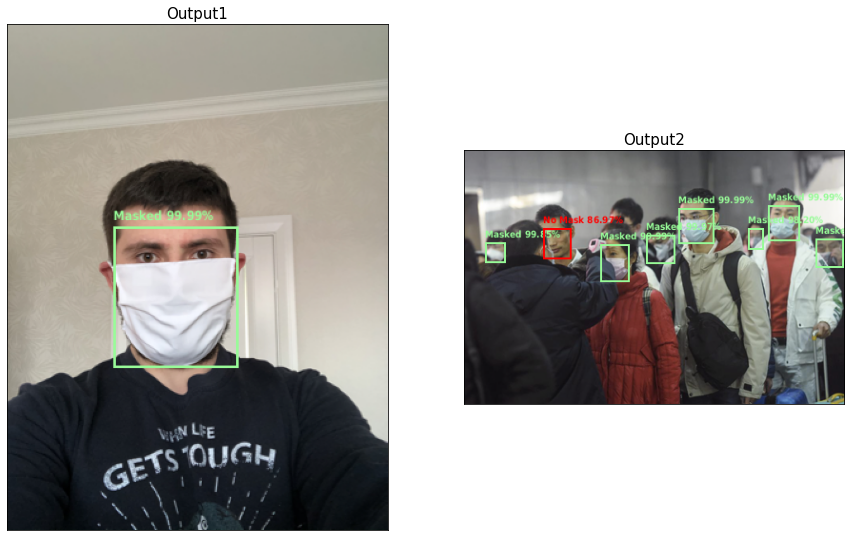

In [22]:
display_images(Output1=display_boundary(images[0], predictions[0]['boxes'], 
                                        predictions[0]['labels'], predictions[0]['scores']),
               Output2=display_boundary(images[1], predictions[1]['boxes'], 
                                        predictions[1]['labels'], predictions[1]['scores']))

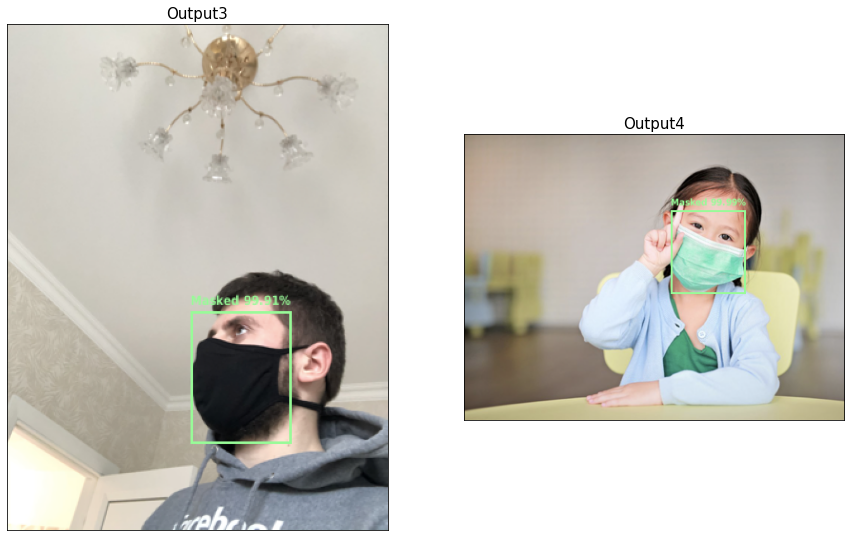

In [23]:
display_images(Output3=display_boundary(images[2], predictions[2]['boxes'], 
                                        predictions[2]['labels'], predictions[2]['scores']),
               Output4=display_boundary(images[3], predictions[3]['boxes'], 
                                        predictions[3]['labels'], predictions[3]['scores']))

## **Run Model on Webcam Images**

<IPython.core.display.Javascript object>

Saved to photo.jpg


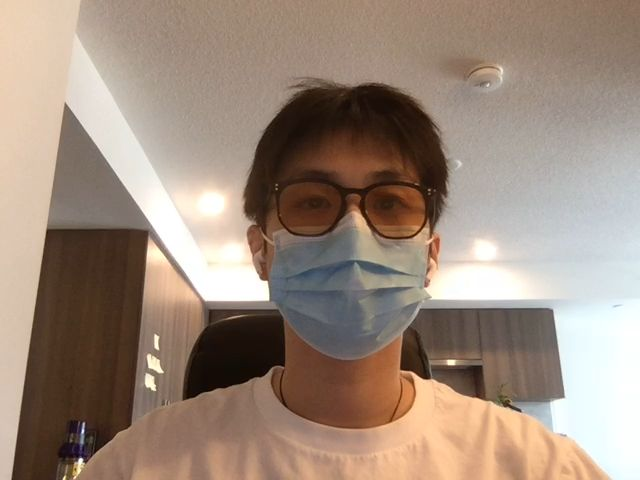

In [27]:
import IPython
from IPython.display import Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  IPython.display.display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  IPython.display.display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

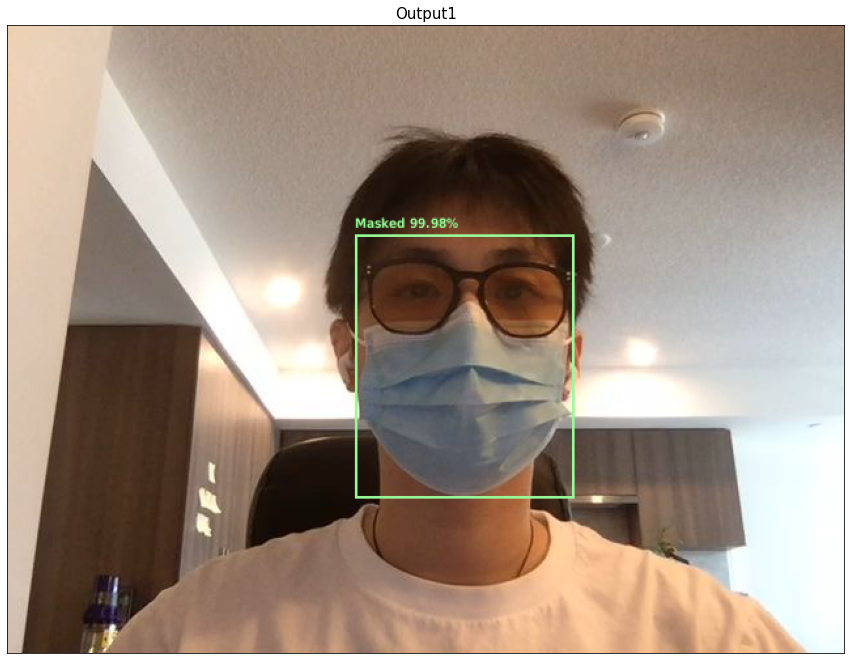

In [30]:
from PIL import Image
from torchvision import transforms

curr_img_dir = '/content/photo.jpg'
image = Image.open(curr_img_dir, mode='r').convert('RGB')

basewidth = 640
wpercent = (basewidth/float(image.size[0]))
hsize = int((float(image.size[1])*float(wpercent)))
image = image.resize((basewidth,hsize), resample=Image.BICUBIC)
tenn = transforms.ToTensor()
image = tenn(image)

model.eval()
predictions = model([image.to(device)])
predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)
predictions = apply_nms(predictions, 0.5)
disp = display_images(Output1=display_boundary(image, predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']))

##**Run Model on Uploaded Files**

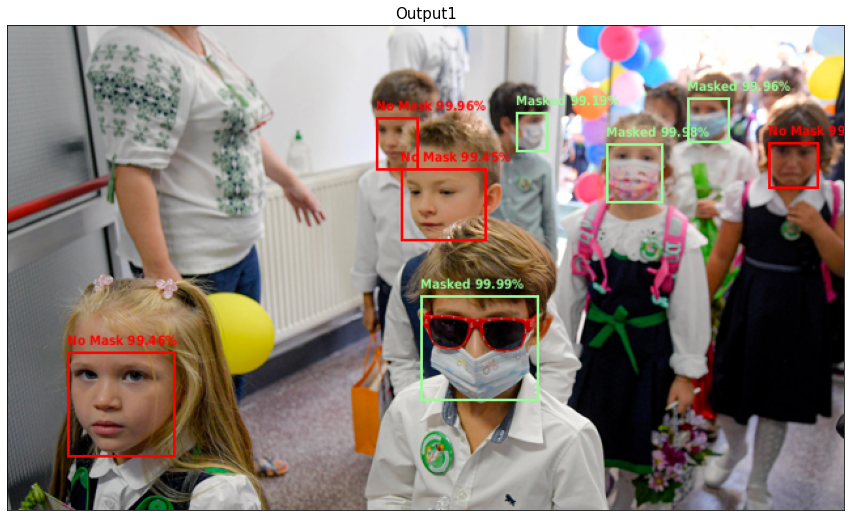

In [35]:
from PIL import Image
from torchvision import transforms

curr_img_dir = '/content/example2.jpg'
image = Image.open(curr_img_dir, mode='r').convert('RGB')

basewidth = 640
wpercent = (basewidth/float(image.size[0]))
hsize = int((float(image.size[1])*float(wpercent)))
image = image.resize((basewidth,hsize), resample=Image.BICUBIC)
tenn = transforms.ToTensor()
image = tenn(image)

model.eval()
predictions = model([image.to(device)])
predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)
predictions = apply_nms(predictions, 0.5)
disp = display_images(Output1=display_boundary(image, predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']))

## **Real-time Recognition on a Live Webcam**

In [36]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [37]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [38]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [44]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''
label_to_name = {1: 'Masked', 2: 'No Mask', }
label_to_color = {1: (102,255,102), 2: (255,102,102)}
tenn = transforms.ToTensor()
transform = torchvision.transforms.ToPILImage()
model.eval()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb = tenn(rgb)

    predictions = model([rgb.to(device)])
    predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)
    predictions = apply_nms(predictions, 0.5)

    # display_boundary
    boxes, labels, scores = predictions[0]['boxes'].tolist(), predictions[0]['labels'].tolist(), predictions[0]['scores']

    for idx in range(len(boxes)):
        left, top, right, bottom = int(boxes[0][0]), int(boxes[0][1]), int(boxes[0][2]), int(boxes[0][3])
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), label_to_color[labels[idx]], 3)
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label_to_name[labels[idx]], float(scores[idx].item())),
                                 (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                                 label_to_color[labels[idx]], 2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

## **Object Detection on Video**

In [45]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 36.2 MB/s eta 0:00:00


In [47]:
# Object Detection on Video

# Importing the libraries
import torch
from torch.autograd import Variable
import imageio # Image processing 
from skimage.transform import resize

# Doing some Object Detection on a video
reader = imageio.get_reader('/content/IMG_5027.MOV') # load the video (if yout want to make object detection on another vidéo, change this line of code) 
fps = reader.get_meta_data()['fps'] # identify the number of frames 
writer = imageio.get_writer('DToutput.mp4', fps = fps) # put the number of frames to te output video

for i, frame in enumerate(reader): # detection for each frame of the video
    frame = resize(frame, (720, 1280, 3))
    tenn = transforms.ToTensor()
    frame = tenn(frame).float() 

    model.eval()
    predictions = model([frame.to(device)])
    predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)

    if len(predictions[0]['boxes'])!=0:
        predictions = apply_nms(predictions, 0.4)
        frame = display_boundary(frame, predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'])
    else:
        transform = torchvision.transforms.ToPILImage()
        frame = transform(frame)
    writer.append_data(np.asarray(frame))

writer.close()